In [19]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random, collections
import time

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# images_foler_path = Path("/content/drive/MyDrive/Colab Notebooks/Data/lfw-deepfunneled/lfw-deepfunneled")
# pairs_folder_path = Path("/content/drive/MyDrive/Colab Notebooks/Data/pairs_approach")
# people_folder_path = Path("/content/drive/MyDrive/Colab Notebooks/Data/people_approach")

In [4]:
Path.cwd()

WindowsPath('c:/Proyectos/George Brown Projects/2 Semester/Math Concepts DL 2/Project')

In [ ]:
images_foler_path = Path("../Data/lfw-deepfunneled/lfw-deepfunneled")
pairs_folder_path = Path("../Data/pairs_approach")
people_folder_path = Path("../Data/people_approach")

In [6]:
def rebuild_image_path(image_name, image_number):
    path = images_foler_path / image_name / f"{image_name}_{image_number:04d}.jpg"
    return path

In [7]:
example1 = rebuild_image_path("Arnold_Schwarzenegger", 17)
example2 = rebuild_image_path("Arnold_Schwarzenegger", 1)
example3 = rebuild_image_path("Aaron_Eckhart", 1)
example1

WindowsPath('Data/lfw-deepfunneled/lfw-deepfunneled/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0017.jpg')

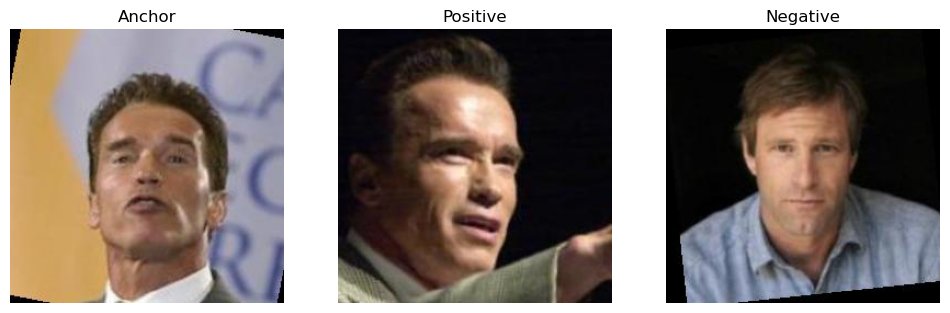

In [8]:
# Given the path, plot the image

def plot_triplet(img_path1, img_path2, img_path3):
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    
    axs[0].imshow(plt.imread(img_path1))
    axs[0].set_title("Anchor")
    axs[1].imshow(plt.imread(img_path2))
    axs[1].set_title("Positive")
    axs[2].imshow(plt.imread(img_path3))
    axs[2].set_title("Negative")
    for ax in axs: ax.axis('off')
    
plot_triplet(example1, example2, example3)

# TODO: Use pillow to read the image and matplotlib to plot it.

# Metadata Preprocess

After the preprocesing the data, each data sample will a triplet of images (A, P, N) where:
- A is an anchor image of a person.
- P is a positive image of the same person.
- N is a negative image of a different person.

The model will be trained to minimize the distance between the embeddings of A and P while maximizing the distance between the embeddings of A and N.

This encourages the model to learn a feature space where images of the same person are closer together, and images of different people are farther apart.

##### Actual data:

🔹**people.csv:**
- Raw list of people and their image counts. In the csv file there is 9 skiped lines to split the data into 10 folds. However, this file won't be use, it's just for reference.

🔹**peopleDevTrain.csv:**
- Training subset with 4038 elements (≈70%).

🔹**peopleDevTest.csv:**
- Testing subset with 1713 elements (≈30%).

The triplets will be created using these last 2 files separately to avoid <u>data leakage</u> of the test set into the training set.


In [9]:
allPeople = pd.read_csv(people_folder_path / "people.csv")
allPeople

,name,images
0,Abdel_Madi_Shabneh,1.0
1,Abdul_Rahman,1.0
2,Abel_Pacheco,4.0
3,Adriana_Lima,1.0
4,Afton_Smith,1.0
...,...,...
5753,Yves_Brodeur,1.0
5754,Zach_Pillar,1.0
5755,Zafarullah_Khan_Jamali,2.0
5756,Zara_Akhmadova,1.0


In [10]:
allPeople.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    5749 non-null   object 
 1   images  5749 non-null   float64
dtypes: float64(1), object(1)
memory usage: 90.1+ KB


In [11]:
peopleTrainFull = pd.read_csv(people_folder_path / "peopleDevTrain.csv")
peopleTest = pd.read_csv(people_folder_path / "peopleDevTest.csv")

print(f"People train shape: {peopleTrainFull.shape}")
print(f"People test shape: {peopleTest.shape}")

People train shape: (4038, 2)
People test shape: (1711, 2)


In [12]:
# compare if there is overlap between train and test sets.
overlap = set(peopleTrainFull.name).intersection(set(peopleTest.name))
print(f"Overlap between train and test sets: {len(overlap)}")

Overlap between train and test sets: 0


In [13]:
peopleTrainFull.name.nunique() # Names can be use as IDs.

4038

In [14]:
# Split peopleTrainFull into train and validation sets:

peopleTrain, peopleVal = train_test_split(peopleTrainFull, test_size=0.2, random_state=42) # Is better to use train_test_split instead of just slicing to ensure randomness.
print(f"Train shape: {peopleTrain.shape}")
print(f"Val shape: {peopleVal.shape}")

Train shape: (3230, 2)
Val shape: (808, 2)


### 🔹Building the TRAINING/VAL dataframe:

In [15]:
singleImsTrain = peopleTrain[peopleTrain.images ==1] # Data set for the negatives of training.
print("Number of people with single image (Train):", len(singleImsTrain))
multiImsTrain = peopleTrain[peopleTrain.images >=2] # Data set for the anchors and positives of training.
print("Number of people with multiple images (Train):", len(multiImsTrain))

singleImsVal = peopleVal[peopleVal.images ==1] # Data set for the negatives of validation.
print("\nNumber of people with single image (Val):", len(singleImsVal))
multiImsVal = peopleVal[peopleVal.images >=2] # Data set for the anchors and positives of validation.
print("Number of people with multiple images (Val):", len(multiImsVal))

multiImsTrain # Glance at one of the data frames (training set with multiple images).

Number of people with single image (Train): 2293
Number of people with multiple images (Train): 937

Number of people with single image (Val): 561
Number of people with multiple images (Val): 247


,name,images
1610,Jack_Straw,28
3188,Ralph_Klein,2
2903,Nicolas_Escude,2
3305,Robert_Blackwill,2
1957,John_Taylor,2
...,...,...
2135,Keira_Knightley,2
3772,Tim_Conway,3
1130,Emmit_Smith,2
1294,Gary_Locke,2


In [16]:
# Different amount of images sets per people:
imSets = np.sort(multiImsTrain.images.unique())
imSets

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  27,  28,
        29,  30,  32,  33,  37,  39,  41,  42,  44,  52,  53,  60, 144,
       236, 530], dtype=int64)

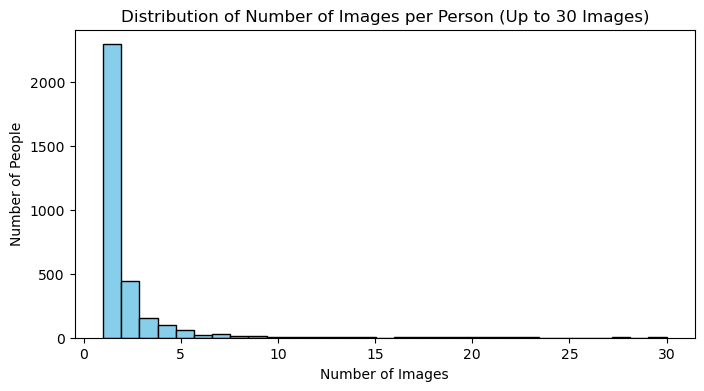

In [18]:
# graph representation of imSets ignoring the ones greater than 30
plt.figure(figsize=(8,4))
plt.hist(peopleTrain.images[peopleTrain.images <= 30], bins=31, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Images per Person (Up to 30 Images)')
plt.xlabel('Number of Images')
plt.ylabel('Number of People')

plt.show()

In [62]:
multiImsTrain

,name,images
1610,Jack_Straw,28
3188,Ralph_Klein,2
2903,Nicolas_Escude,2
3305,Robert_Blackwill,2
1957,John_Taylor,2
...,...,...
2135,Keira_Knightley,2
3772,Tim_Conway,3
1130,Emmit_Smith,2
1294,Gary_Locke,2


# Datasets "on-the-fly" Contruction:

In [ ]:
# maps persons -> list of paths. The names are used as IDs.
def build_paths_dicc(df):
    by_id = collections.defaultdict(list)
    for _, row in df.iterrows(): # To iterate over rows. By default, dfs are iterated over columns.
        name, n = row['name'], row["images"]
        for i in range(1, n+1):
            by_id[name].append(rebuild_image_path(name, i))
    return by_id

""" For training set:"""
by_id_multi_train  = build_paths_dicc(multiImsTrain)
by_id_single_train = build_paths_dicc(singleImsTrain) # The lists in this dicctionary will have only one element.
by_id_all_train    = {**by_id_multi_train, **by_id_single_train} # Unpack both dictionaries into a new one.
ids_multi_train    = list(by_id_multi_train.keys())
ids_all_train      = list(by_id_all_train.keys())
""" For validation set:"""
by_id_multi_val  = build_paths_dicc(multiImsVal)
by_id_single_val = build_paths_dicc(singleImsVal) # The lists in this dicctionary will have only one element.
by_id_all_val    = {**by_id_multi_val, **by_id_single_val} # Unpack both dictionaries into a new one.
ids_multi_val    = list(by_id_multi_val.keys())
ids_all_val      = list(by_id_all_val.keys())


In [155]:
def sample_triplet(set=''):
    # Previous conditions to determine which set to use:
    if set == 'train':
        by_id_multi = by_id_multi_train
        by_id_all   = by_id_all_train
        ids_multi   = ids_multi_train
        ids_all     = ids_all_train
    elif set == 'val':
        by_id_multi = by_id_multi_val
        by_id_all   = by_id_all_val
        ids_multi   = ids_multi_val
        ids_all     = ids_all_val
    else:
        raise ValueError("Set must be either 'train' or 'val'.")
    
    # Actuall triplet construction:
    id_pos = random.choice(ids_multi)
    a, p = random.sample(by_id_multi[id_pos], 2)
    id_neg = random.choice([id for id in ids_all if id != id_pos])
    n = random.choice(by_id_all[id_neg])
    return str(a), str(p), str(n) # These are the paths of the images. Converted to str to avoid issues with tensorflow.



In [151]:
example_triplet = sample_triplet(set='train')
example_triplet

('Data\\lfw-deepfunneled\\lfw-deepfunneled\\Lina_Krasnoroutskaya\\Lina_Krasnoroutskaya_0002.jpg',
 'Data\\lfw-deepfunneled\\lfw-deepfunneled\\Lina_Krasnoroutskaya\\Lina_Krasnoroutskaya_0001.jpg',
 'Data\\lfw-deepfunneled\\lfw-deepfunneled\\John_Manley\\John_Manley_0004.jpg')

In [147]:
# Constants:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

In [159]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def augment(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img

print(tf.shape(load_img(example_triplet[0])))
print(tf.shape(augment(load_img(example_triplet[0]))))

tf.Tensor([160 160   3], shape=(3,), dtype=int32)
tf.Tensor([160 160   3], shape=(3,), dtype=int32)


In [208]:
# This is the generator function that will be used by tf.data.Dataset.from_generator.
def generator(set=''):
    while True:
        yield sample_triplet(set) # yield allows to return one item at a time, resuming where it left off, the next time it's called.

In [ ]:
# This dataset does not store the data in memory. It will be created "on-the-fly" during training/validation.
# Datasets "on-the-fly" Contruction:
def make_ds(set=''):
    ds = tf.data.Dataset.from_generator(                # ds is a Dataset object.
        lambda: generator(set),                         # from_generator creates an iterator using the generator function.
        output_signature=(                              # The output is a triplet of tensors.
            tf.TensorSpec(shape=(), dtype=tf.string),   # The dim of each tensor is 0.
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string),
        )
    )
    def _map(a,p,n):
        im_a, im_p, im_n = load_img(a), load_img(p), load_img(n)
        if set == 'train':
            im_a, im_p, im_n = augment(im_a), augment(im_p), augment(im_n)
        
        y_dummy = tf.zeros((), dtype=tf.float32) # Create a dummy label. It is ignored in the loss funtion.
        
        return (im_a, im_p, im_n), y_dummy
    
    # Apply transformations:
    # (The parameter "num_parallel_calls = tf.data.AUTOTUNE" allows tensorflow to use all the available CPU cores.)
    ds = ds.map(_map, num_parallel_calls = tf.data.AUTOTUNE) # Here, _map is applied to each element of ds. 
    ds = ds.batch(BATCH_SIZE)                                # Then, the elements are grouped into batches of size BATCH_SIZE.
    ds = ds.prefetch(tf.data.AUTOTUNE)                       # Finally, the prefetch function allows the CPU to prepare the next batch while the GPU is working on the previous one.
    
    return ds
    
    """ Ex:(
  batch_a: (32,3,160,160,3),
  batch_p: (32,3,160,160,3),
  batch_n: (32,3,160,160,3)
)"""

In [210]:
make_ds(set='train')
# (None, 160,160,3) instead of (32,160,160,3) because that dim can change during the execution since the last batch in general has a smaller size.

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# Model and Training:

In [ ]:
EMB_DIM = 128

def build_embedding_model():
    base = tf.keras.applications.MobileNetV2(
        input_shape = (*IMG_SIZE, 3), include_top=False, weights='imagenet'
    )
    
    base.trainable = False
    
    inputs = tf.keras.Input(shape = (*IMG_SIZE, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x, training = False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(EMB_DIM, use_bias=False)(x)
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=-1))(x)
    
    return tf.keras.Model(inputs, x, name="embedding")

def triplet_loss(margin=0.2):
    def loss(y_true, y_pred): # y_true is not used.
        dim = EMB_DIM
        ea, ep, en = y_pred[:, :dim], y_pred[:, dim:2*dim], y_pred[:, 2*dim:]
        dap = tf.reduce_sum(tf.square(ea - ep), axis=1)
        dan = tf.reduce_sum(tf.square(ea - en), axis=1)
        return tf.reduce_mean(tf.maximum(0.0, dap - dan + margin))
    return loss

def build_triplet_net(embedding_model):
    a = tf.keras.Input(shape = (*IMG_SIZE, 3))
    p = tf.keras.Input(shape = (*IMG_SIZE, 3))
    n = tf.keras.Input(shape = (*IMG_SIZE, 3))
    ea, ep, en = embedding_model(a), embedding_model(p), embedding_model(n)
    merged = layers.Concatenate(axis=1)([ea, ep, en])
    return tf.keras.Model([a,p,n], merged, name="triplet_net")

In [ ]:
embedding = build_embedding_model()
triplet_net = build_triplet_net(embedding)

triplet_net.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=triplet_loss(margin=0.2)
)

train_ds = make_ds(set='train')
val_ds   = make_ds(set='val')

start_time = time.time()

history = triplet_net.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=50,
    validation_steps=10,
    epochs=15,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

end_time = time.time()
train_time_min = (end_time - start_time) // 60
train_time_sec = (end_time - start_time) % 60
print(f"Training time: {train_time_min} min {train_time_sec} sec")

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 0.1086 - val_loss: 0.0808
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.0863 - val_loss: 0.0887
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0772 - val_loss: 0.0702
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 0.0695 - val_loss: 0.0848
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.0565 - val_loss: 0.0675
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.0636 - val_loss: 0.0769
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 0.0614 - val_loss: 0.0852
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 0.0574 - val_loss: 0.0626
Epoch 9/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.0486 - val_loss: 0.0854
Epoch 10/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 0.0532 - val_loss: 0.0699
Epoch 11/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 0.0516 - val_loss: 0.0703


In [224]:
history.history

{'loss': [0.10857103019952774,
  0.0862879529595375,
  0.07724215090274811,
  0.06947942078113556,
  0.05650283768773079,
  0.06357643008232117,
  0.06136032193899155,
  0.057387810200452805,
  0.048570889979600906,
  0.05324825271964073,
  0.051610901951789856],
 'val_loss': [0.0808296948671341,
  0.0886925458908081,
  0.07023350894451141,
  0.0848296508193016,
  0.06746888160705566,
  0.07693425565958023,
  0.08520955592393875,
  0.0625893622636795,
  0.08538518846035004,
  0.06991828978061676,
  0.0702560693025589]}

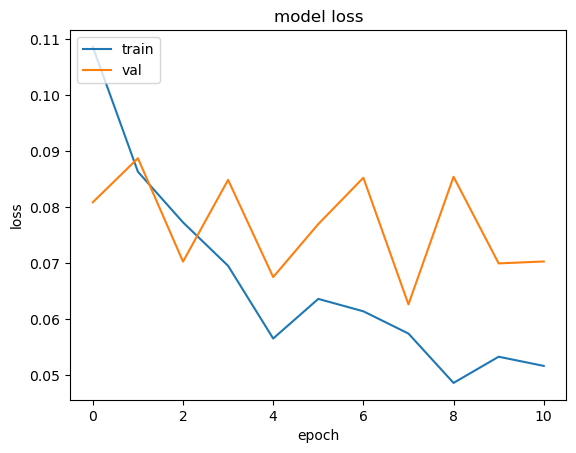

In [235]:
# Visualization of the training process:
# shift the x axis to the left to see the training from epoch 1

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test

In [237]:
peopleTest

,name,images
0,AJ_Lamas,1
1,Aaron_Guiel,1
2,Aaron_Tippin,1
3,Abba_Eban,1
4,Abdul_Majeed_Shobokshi,1
...,...,...
1706,Zhang_Ziyi,4
1707,Zoe_Ball,1
1708,Zoran_Djindjic,4
1709,Zulfiqar_Ahmed,1


In [241]:
singleImsTest = peopleTest[peopleTest.images == 1]
multiImsTest = peopleTest[peopleTest.images > 1]

print("Number of people with single image (Test):", len(singleImsTest))
print("Number of people with multiple images (Test):", len(multiImsTest))

Number of people with single image (Test): 1215
Number of people with multiple images (Test): 496


In [ ]:
""" For testing set:"""
by_id_multi_test  = build_paths_dicc(multiImsTest)
by_id_single_test = build_paths_dicc(singleImsTest) # The lists in this dicctionary will have only one element.
by_id_all_test    = {**by_id_multi_test, **by_id_single_test} # Unpack both dictionaries into a new one.
ids_multi_test    = list(by_id_multi_test.keys())
ids_all_test      = list(by_id_all_test.keys())


In [243]:
def sample_pairs(label):
    if label == 'pos':
        id_pos = random.choice(ids_multi_test)
        p1, p2 = random.sample(by_id_multi_test[id_pos], 2)
        return str(p1), str(p2)
    elif label == 'neg':
        id_neg1 = random.choice(ids_all_test)
        n1 = random.choice(by_id_all_test[id_neg1])
        id_neg2 = random.choice([id for id in ids_all_test if id != id_neg1])
        n2 = random.choice(by_id_all_test[id_neg2])
        return str(n1), str(n2) 
    else:
        raise ValueError("Label must be either 'pos' or 'neg'.")

In [246]:
def make_pairs_dataset(num_pos, num_neg):
    paths1 = []
    paths2 = []
    labels = []  # 1 = same, 0 = different

    for _ in range(num_pos):
        p1, p2 = sample_pairs('pos')
        paths1.append(p1)
        paths2.append(p2)
        labels.append(1)

    for _ in range(num_neg):
        n1, n2 = sample_pairs('neg')
        paths1.append(n1)
        paths2.append(n2)
        labels.append(0)

    paths1 = np.array(paths1)
    paths2 = np.array(paths2)
    labels = np.array(labels, dtype=np.int32)
    return paths1, paths2, labels

In [273]:
# Example:
val_paths1, val_paths2, val_labels = make_pairs_dataset(1000, 1000)     # Will be use to calculate the best threshold to determine if they are the same person or not.
test_paths1, test_paths2, test_labels = make_pairs_dataset(1000, 1000)

df = pd.DataFrame({'path1': test_paths1, 'path2': test_paths2, 'label': test_labels})
df[997:1003]

,path1,path2,label
997,Data\lfw-deepfunneled\lfw-deepfunneled\Megan_Mullally\Megan_Mullally_0001.jpg,Data\lfw-deepfunneled\lfw-deepfunneled\Megan_Mullally\Megan_Mullally_0002.jpg,1
998,Data\lfw-deepfunneled\lfw-deepfunneled\Penelope_Cruz\Penelope_Cruz_0001.jpg,Data\lfw-deepfunneled\lfw-deepfunneled\Penelope_Cruz\Penelope_Cruz_0002.jpg,1
999,Data\lfw-deepfunneled\lfw-deepfunneled\Vaclav_Havel\Vaclav_Havel_0004.jpg,Data\lfw-deepfunneled\lfw-deepfunneled\Vaclav_Havel\Vaclav_Havel_0009.jpg,1
1000,Data\lfw-deepfunneled\lfw-deepfunneled\Nikki_Teasley\Nikki_Teasley_0001.jpg,Data\lfw-deepfunneled\lfw-deepfunneled\Princess_Stephanie\Princess_Stephanie_0001.jpg,0
1001,Data\lfw-deepfunneled\lfw-deepfunneled\Sebastian_Cuattrin\Sebastian_Cuattrin_0001.jpg,Data\lfw-deepfunneled\lfw-deepfunneled\Joseph_Deiss\Joseph_Deiss_0001.jpg,0
1002,Data\lfw-deepfunneled\lfw-deepfunneled\Begum_Khaleda_Zia\Begum_Khaleda_Zia_0001.jpg,Data\lfw-deepfunneled\lfw-deepfunneled\Hussam_Mohammed_Amin\Hussam_Mohammed_Amin_0001.jpg,0


In [264]:
def make_pairs_ds(paths1, paths2, labels, batch_size=64, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths1, paths2, labels)) 
    # The slices method creates a Dataset object. Visualy looks like a df but optimized for tensorflow.

    def _map(p1, p2, y):
        im1 = load_img(p1)
        im2 = load_img(p2)
        if training:
            im1 = augment(im1)
            im2 = augment(im2)
        return (im1, im2), y

    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [274]:
# Example:
val_pairs_ds  = make_pairs_ds(val_paths1,  val_paths2,  val_labels,  training=False)
test_pairs_ds = make_pairs_ds(test_paths1, test_paths2, test_labels, training=False)
test_pairs_ds

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [275]:
def compute_embeddings(embedding_model, ds):
    embs1_list, embs2_list, labels_list = [], [], []
    for (imgs1, imgs2), y in ds:
        e1 = embedding_model.predict(imgs1, verbose=0)
        e2 = embedding_model.predict(imgs2, verbose=0)
        embs1_list.append(e1)
        embs2_list.append(e2)
        labels_list.append(y.numpy())
    embs1 = np.vstack(embs1_list)
    embs2 = np.vstack(embs2_list)
    labels = np.concatenate(labels_list)
    return embs1, embs2, labels

val_e1,  val_e2,  val_y  = compute_embeddings(embedding, val_pairs_ds)
test_e1, test_e2, test_y = compute_embeddings(embedding, test_pairs_ds)

print(test_e1.shape, test_e2.shape, test_y.shape)


(2000, 128) (2000, 128) (2000,)


In [276]:
# L2 distance:
def l2_dist(a, b):
    return np.sqrt(np.sum((a - b)**2, axis=1))

val_dists  = l2_dist(val_e1,  val_e2)
test_dists = l2_dist(test_e1, test_e2)
test_dists.shape

(2000,)

In [278]:
ts = np.linspace(0, 2.0, 200)
best_acc, best_t = 0.0, None

for t in ts:
    preds = (val_dists < t).astype(int)
    acc = (preds == val_y).mean()
    if acc > best_acc:
        best_acc, best_t = acc, t

print("Optimun threshold (val):", best_t, "Acc val:", best_acc)


Optimun threshold (val): 0.6934673366834171 Acc val: 0.7875


In [279]:
test_preds = (test_dists < best_t).astype(int)
test_acc = (test_preds == test_y).mean()
print("Accuracy test:", test_acc)


Accuracy test: 0.7815


In [283]:
def eval_pairs_dataset(embedding_model, pairs_ds, threshold):
    embs1_list, embs2_list, labels_list = [], [], []
    for (imgs1, imgs2), y in pairs_ds:
        e1 = embedding_model.predict(imgs1, verbose=0)
        e2 = embedding_model.predict(imgs2, verbose=0)
        embs1_list.append(e1)
        embs2_list.append(e2)
        labels_list.append(y.numpy())

    e1 = np.vstack(embs1_list)
    e2 = np.vstack(embs2_list)
    y_true = np.concatenate(labels_list)

    dists = np.sqrt(np.sum((e1 - e2) ** 2, axis=1))
    y_pred = (dists < threshold).astype(int) # 1: same, 0: different.
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)

    return acc, f1, prec, rec


In [290]:
# train_acc, train_f1, train_prec, train_rec = eval_pairs_dataset(embedding, train_pairs_ds, best_t)
val_acc,   val_f1,   val_prec,   val_rec   = eval_pairs_dataset(embedding, val_pairs_ds,   best_t)

# print("Train acc:", train_acc)
print("Val acc:",   val_acc)


Val acc: 0.7875


In [291]:
train_loss = history.history["loss"][-1]
val_loss   = history.history["val_loss"][-1]

In [292]:
triplet_params = triplet_net.count_params()
embeding_params = embedding.count_params()
params = triplet_params + embeding_params 
print("Parameters:", params)

Parameters: 5237376


In [293]:
results = {
    # "train_accuracy": train_acc,
    "val_accuracy":   val_acc,
    "train_loss":     train_loss,
    "val_loss":       val_loss,
    "f1_score":       val_f1,
    "precision":      val_prec,
    "recall":         val_rec,
    "params":         params,
    "train_time":     f"{train_time_min} : {train_time_sec}"
}

df = pd.DataFrame([results])
df.to_csv("lfw_triplet_results.csv", index=False)
print(df)


NameError: name 'train_time_min' is not defined

In [33]:
# Read the results and display them vertically
pd.read_csv("lfw_triplet_results.csv").round(2).transpose()



,0
val_accuracy,0.78
train_loss,0.05
val_loss,0.07
f1_score,0.77
precision,0.81
recall,0.74
params,5237376
train_time,23.0 : 11.302153825759888
